# Predicting Stock Market Trends Using ARIMA Models

## Problem Statement

# This study aims to apply the ARIMA model to analyze and forecast Old Mutual’s stock price trends. By evaluating stationarity, differencing techniques, and walk-forward validation, the project seeks to determine the model’s predictive accuracy and its ability to capture market trends. The findings could help investors improve decision-making strategies and enhance financial risk management.

# Hypothesis

### The ARIMA model can effectively forecast Old Mutual’s stock price trends on the London Stock Exchange by capturing underlying patterns in historical data. However, forecasting accuracy is expected to decline in periods of high market volatility, requiring further model adjustments such as seasonal components or hybrid approaches.

# Data Collection 

### This study utilizes historical stock price data for Old Mutual (ticker: OMU) obtained from Investing.com. The dataset includes daily stock prices, trading volume, and percentage price changes recorded over a period of 6,541 trading days.

## Importing the Libraries

In [259]:
import piplite
await piplite.install("seaborn")
await piplite.install("plotly")


In [260]:

import time
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Load the Data

In [261]:
df=pd.read_csv("OMU.LSE.csv")

## Explore the Data

In [262]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,5/12/2025,49.4,50.2,51.0,49.2,270.88K,0.20%
1,5/9/2025,49.3,46.2,50.0,46.1,1.01M,7.88%
2,5/8/2025,45.7,45.3,45.7,45.0,70.05K,2.01%
3,5/7/2025,44.8,45.9,46.0,44.8,252.35K,-2.61%
4,5/6/2025,46.0,46.2,46.2,45.4,494.14K,-1.50%


In [263]:
df.shape

(6541, 7)

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6541 entries, 0 to 6540
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      6541 non-null   object 
 1   Price     6541 non-null   float64
 2   Open      6541 non-null   float64
 3   High      6541 non-null   float64
 4   Low       6541 non-null   float64
 5   Vol.      6525 non-null   object 
 6   Change %  6541 non-null   object 
dtypes: float64(4), object(3)
memory usage: 281.1+ KB


In [265]:
df.describe()

,Price,Open,High,Low
count,6541.000000,6541.000000,6541.000000,6541.000000
mean,66.934272,66.972163,67.926615,65.991562
std,20.605497,20.614225,20.693637,20.543067
min,0.940000,0.940000,0.940000,0.940000
25%,50.740000,50.800000,51.550000,49.850000
50%,63.150000,63.220000,64.050000,62.250000
75%,84.860000,84.950000,85.910000,83.850000
max,126.550000,125.940000,126.950000,125.540000


### Data Preprocessing

In [266]:
#Remove Unnecessary columns
df.drop(columns=["Open","High","Low","Vol.","Change %"],inplace=True)


In [267]:
#Check for dupilcates and remove them
if df.duplicated().any():
    df.drop_duplicates(inplace=True)
else:
    pass

In [268]:
# Set the date column  frequency as daily
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.set_index("Date", inplace=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6540 entries, 2025-05-12 to 1999-07-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   6540 non-null   float64
dtypes: float64(1)
memory usage: 102.2 KB
None
DatetimeIndex(['2025-05-12', '2025-05-09', '2025-05-08', '2025-05-07',
               '2025-05-06', '2025-05-02', '2025-05-01', '2025-04-30',
               '2025-04-29', '2025-04-28',
               ...
               '1999-07-26', '1999-07-23', '1999-07-22', '1999-07-21',
               '1999-07-20', '1999-07-19', '1999-07-16', '1999-07-15',
               '1999-07-14', '1999-07-13'],
              dtype='datetime64[ns]', name='Date', length=6540, freq=None)
            Price
Date             
2025-05-12   49.4
2025-05-09   49.3
2025-05-08   45.7
2025-05-07   44.8
2025-05-06   46.0


In [269]:
#Check for null vaues and delete them
if df.isna().any().any():
    df.dropna(inplace=True)
else:
    pass

### Visual Explorations

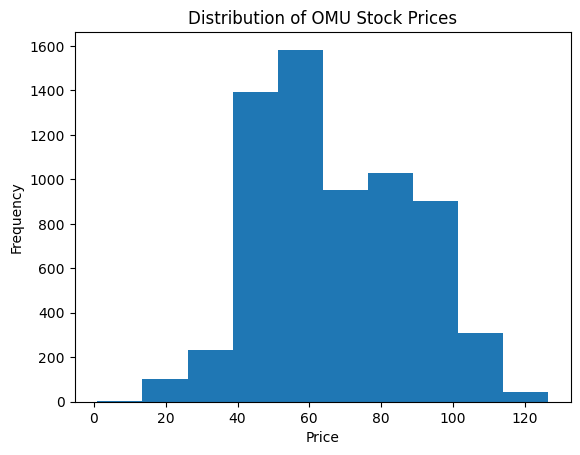

In [270]:
#Distribution of Stock Prices
df["Price"].plot(kind="hist")
plt.xlabel("Price")
plt.title("Distribution of OMU Stock Prices");


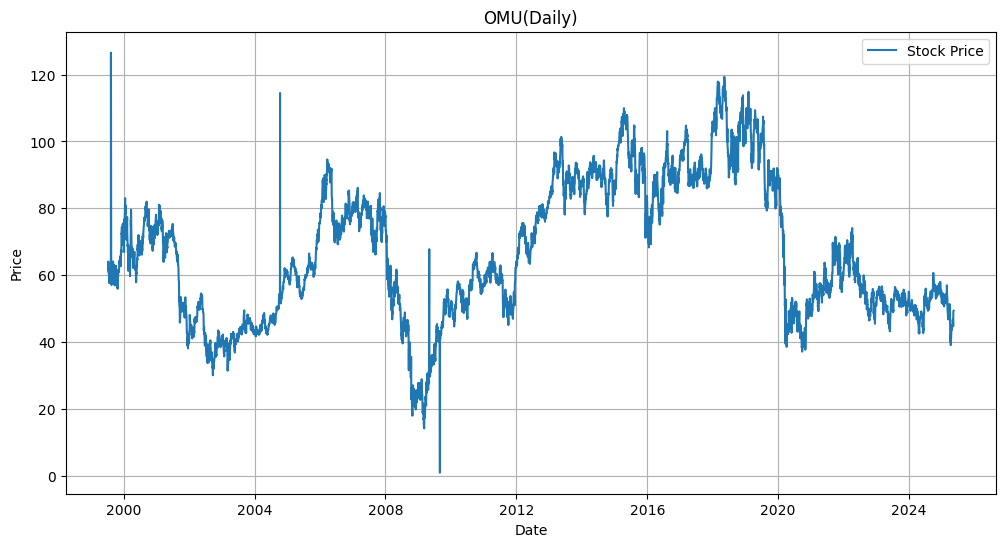

In [271]:
# Price Chart
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label="Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("OMU(Daily)")
plt.legend()
plt.grid()
plt.show();

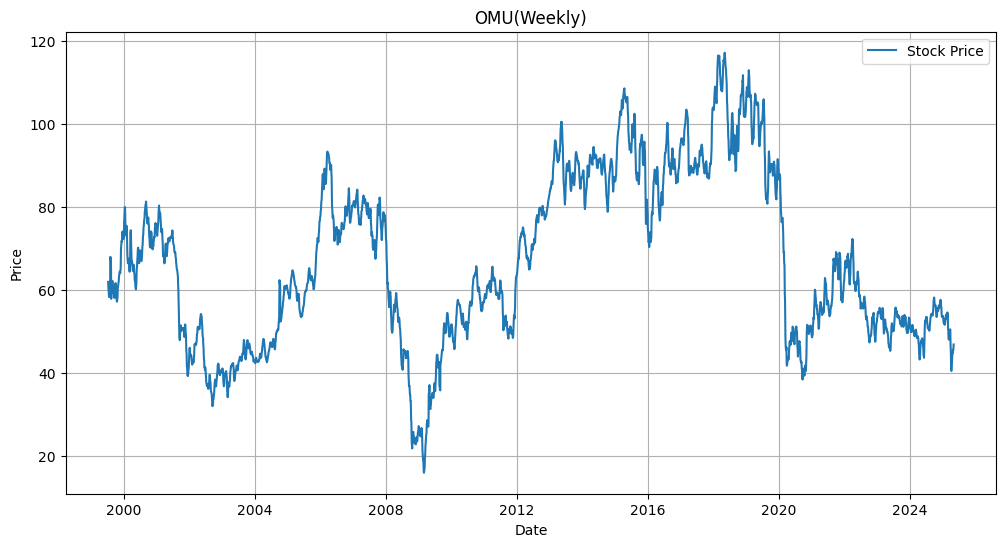

In [272]:
# Weekly Chart
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'].rolling(7).mean(), label="Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("OMU(Weekly)")
plt.legend()
plt.grid()
plt.show();
                       
                       

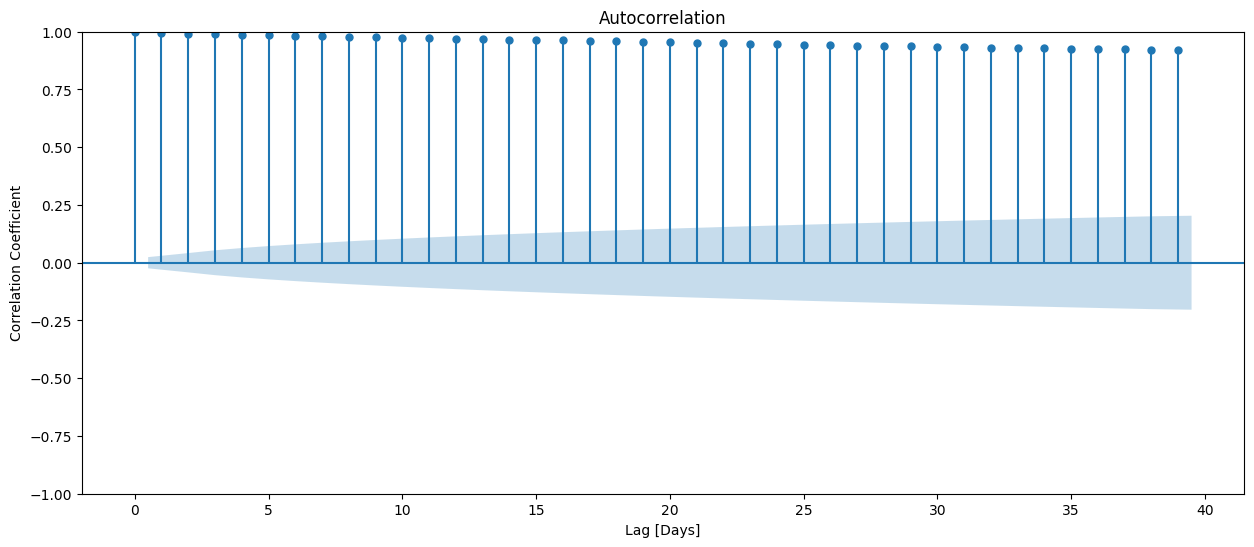

In [273]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df,ax=ax)

plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

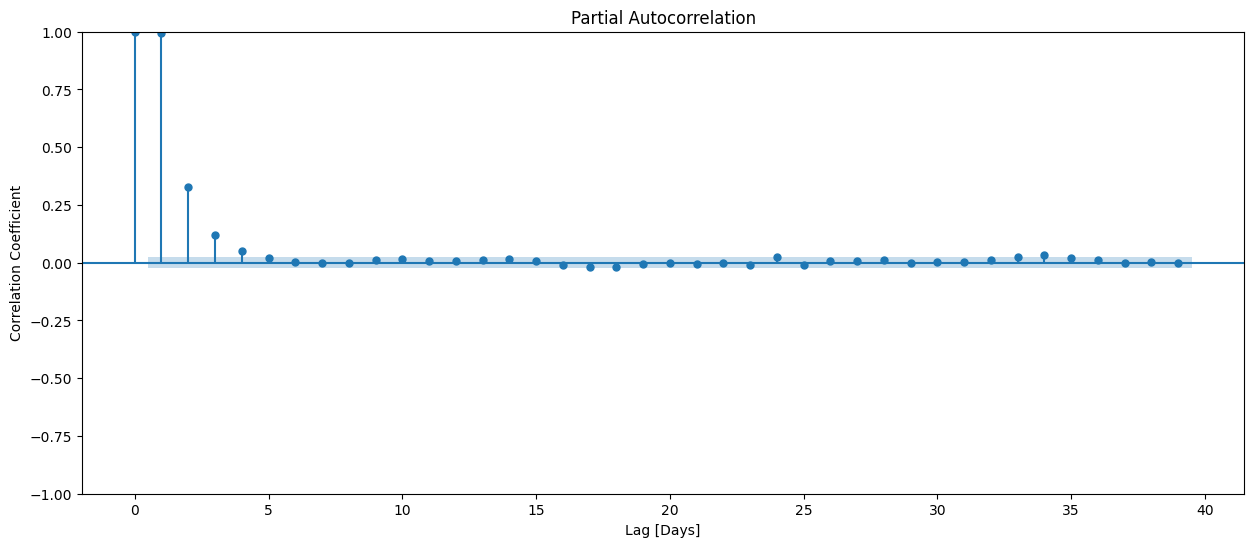

In [274]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df,ax=ax)

plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

#### It looks like the Price is trending
#### Check for stationarity:Augmented Dickey-Fuller (ADF) Test

In [275]:
result = adfuller(df['Price'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The data is stationary (reject null hypothesis).")
else:
    print("The data is non-stationary (fail to reject null hypothesis).")

ADF Statistic: -2.77022959056423
p-value: 0.06265369823759434
The data is non-stationary (fail to reject null hypothesis).


### Applying Differencing

In [276]:
df['Price_diff'] = df['Price'].diff()

In [277]:
### Test with the differenced Data

df.dropna(inplace=True)

# Run ADF test on the cleaned differenced series
result = adfuller(df['Price_diff'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The data is stationary (reject null hypothesis).")
else:
    print("The data is still non-stationary (apply second differencing).")


ADF Statistic: -48.149646622903326
p-value: 0.0
The data is stationary (reject null hypothesis).


### We need to Perfom differencing Once for the Data

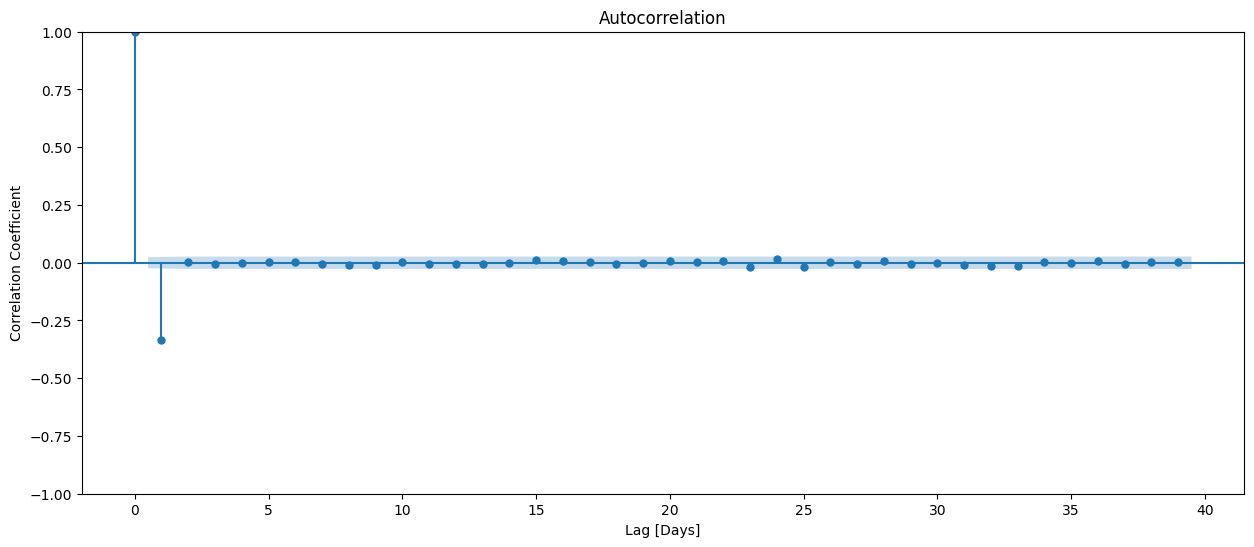

In [278]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df.drop(columns="Price"),ax=ax)

plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

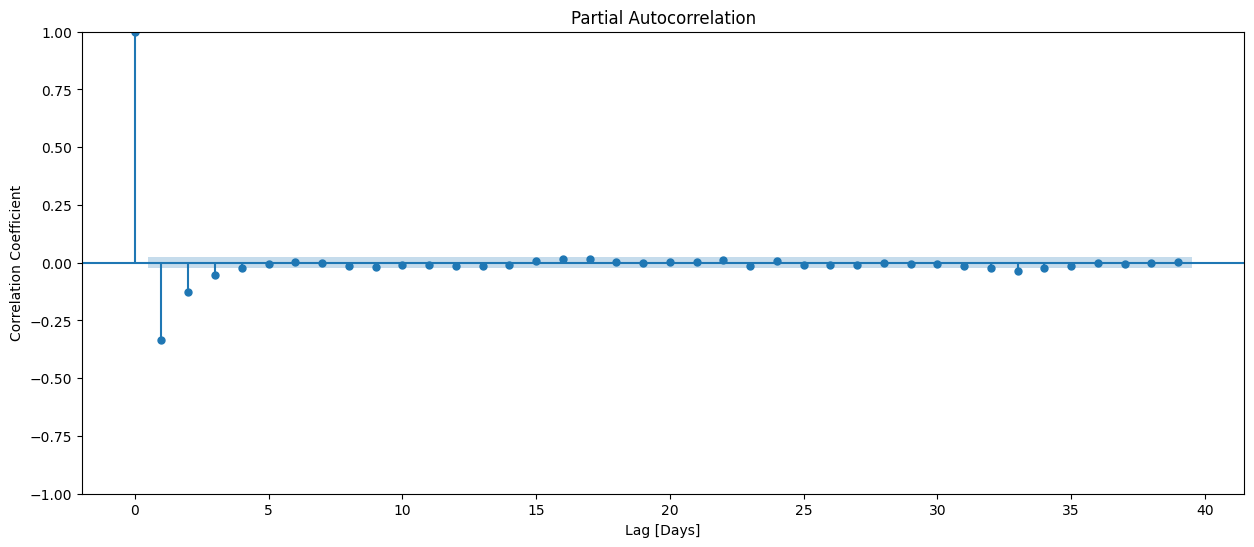

In [279]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df.drop(columns="Price"),ax=ax)

plt.xlabel("Lag [Days]")
plt.ylabel("Correlation Coefficient");

In [280]:
df.drop(columns="Price_diff",inplace=True)

### Looking at the PLot ,it Lokks like the values for q range from 0-3
### and those for p ranges from 0-4

## Model Development

In [281]:
### Split The Data
cutoff_test =int(len(df)*0.9)
y_train =df.iloc[:cutoff_test]
y_test =df.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (5885, 1)
y_test shape: (654, 1)


### Baseline Model

In [282]:
y_train_mean =y_train.mean()
y_pred_baseline =[y_train_mean]*len(y_train)
mae_baseline =mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:$", round(mae_baseline,2))

Mean P2 Reading: Price    67.076404
dtype: float64
Baseline MAE:$ 18.74


## Hyperparameter Tuning

In [283]:
p_params=range(0,5)
q_params=range(0,4)

In [284]:
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 1, q)
        # Note start time
        start_time = time.time()
        # Train model
        model =ARIMA(y_train,order=order).fit(method_kwargs={"dips":0})
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred =model.predict()
        # Calculate training MAE
        mae =mean_absolute_error(y_train,y_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 1, 0) in 0.25 seconds.
Trained ARIMA (0, 1, 1) in 0.34 seconds.
Trained ARIMA (0, 1, 2) in 0.63 seconds.
Trained ARIMA (0, 1, 3) in 0.79 seconds.
Trained ARIMA (1, 1, 0) in 0.37 seconds.
Trained ARIMA (1, 1, 1) in 0.42 seconds.
Trained ARIMA (1, 1, 2) in 1.03 seconds.
Trained ARIMA (1, 1, 3) in 1.22 seconds.
Trained ARIMA (2, 1, 0) in 0.58 seconds.
Trained ARIMA (2, 1, 1) in 3.27 seconds.
Trained ARIMA (2, 1, 2) in 1.76 seconds.
Trained ARIMA (2, 1, 3) in 12.7 seconds.
Trained ARIMA (3, 1, 0) in 0.75 seconds.
Trained ARIMA (3, 1, 1) in 6.13 seconds.
Trained ARIMA (3, 1, 2) in 8.21 seconds.
Trained ARIMA (3, 1, 3) in 4.8 seconds.
Trained ARIMA (4, 1, 0) in 0.71 seconds.
Trained ARIMA (4, 1, 1) in 3.77 seconds.
Trained ARIMA (4, 1, 2) in 12.69 seconds.
Trained ARIMA (4, 1, 3) in 15.04 seconds.

{0: [np.float64(1.0638283772302513), np.float64(1.1187110729292473), np.float64(1.1187418546335028), np.float64(1.1187395032150997)], 1: [np.float64(1.1036037390768447), np.float

In [285]:
mae_df =pd.DataFrame(mae_grid)
mae_df.round(4)

,0,1,2,3,4
0,1.0638,1.1036,1.1159,1.1184,1.1188
1,1.1187,1.1187,1.1187,1.1188,1.1189
2,1.1187,1.1187,1.1187,1.1186,1.1181
3,1.1187,1.1187,1.1188,1.1187,1.1176


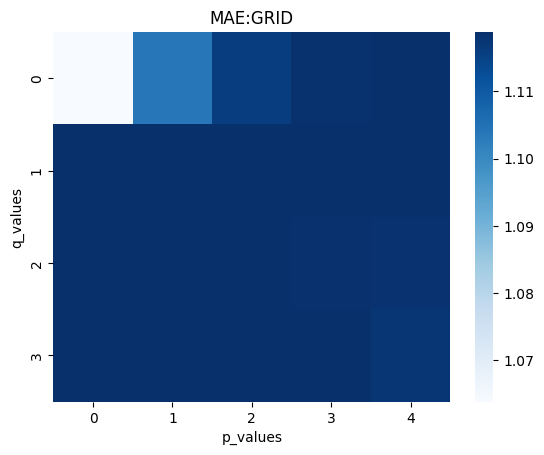

In [286]:
sns.heatmap(mae_df,cmap="Blues")
plt.xlabel("p_values")
plt.ylabel("q_values")
plt.title("MAE:GRID");

### Looking at the Grid, we see that the model trained with the order (1,1,1) has a lower Mean absolute Error of 1.12 which shows a huge improvement from the baseline model MAE of $18.74 

## Plotting Residuals For The Training Data

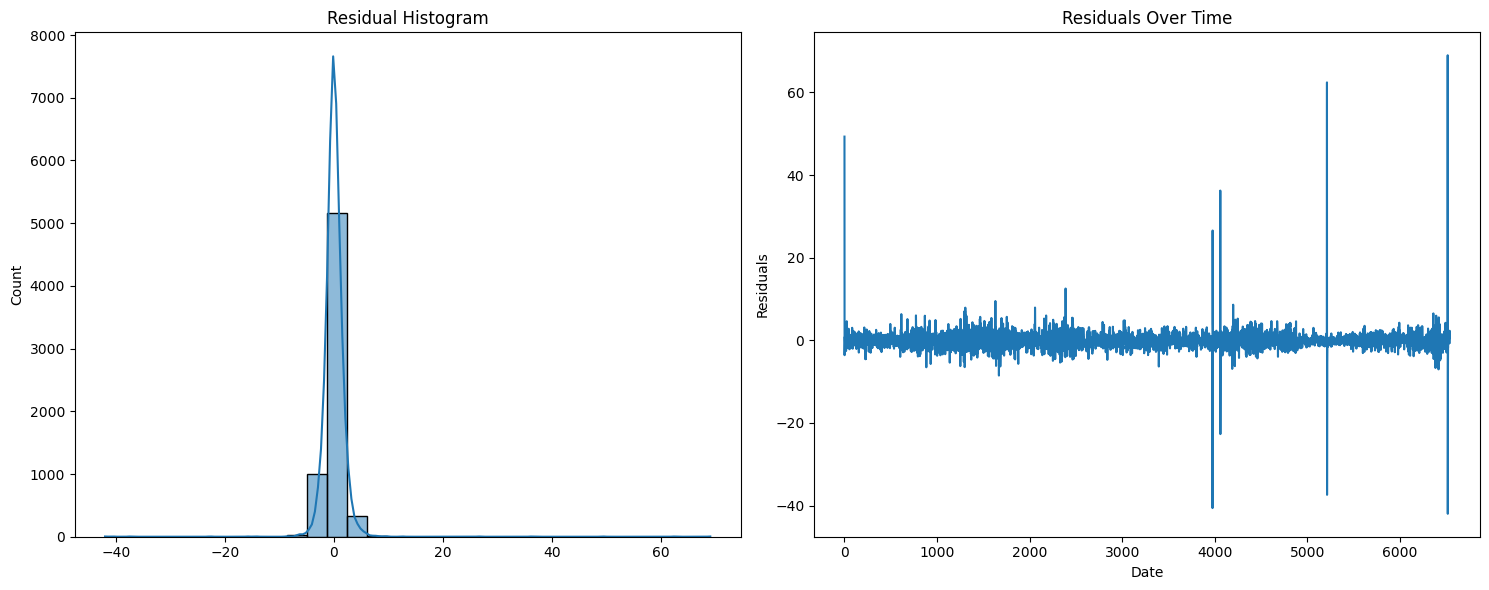

In [287]:
residuals = model_fit.resid

# Create subplots for diagnostics
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residual distribution
sns.histplot(residuals, bins=30, kde=True, ax=axes[0])
axes[0].set_title("Residual Histogram")

# Residual time series
axes[1].plot(residuals)
axes[1].set_title("Residuals Over Time")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Residuals")

plt.tight_layout()
plt.show()

### The residuals of the ARIMA model are centered around zero, indicating that the model's predictions are unbiased. This suggests that the model has successfully captured the underlying trend in Old Mutual's stock prices without systematic over- or underestimation. Furthermore, the absence of a strong pattern in residuals implies that the model's errors are random, confirming that the fitted ARIMA model is appropriate for this dataset. However, further tests, such as the Ljung-Box test, may be needed to ensure that the residuals represent true white noise

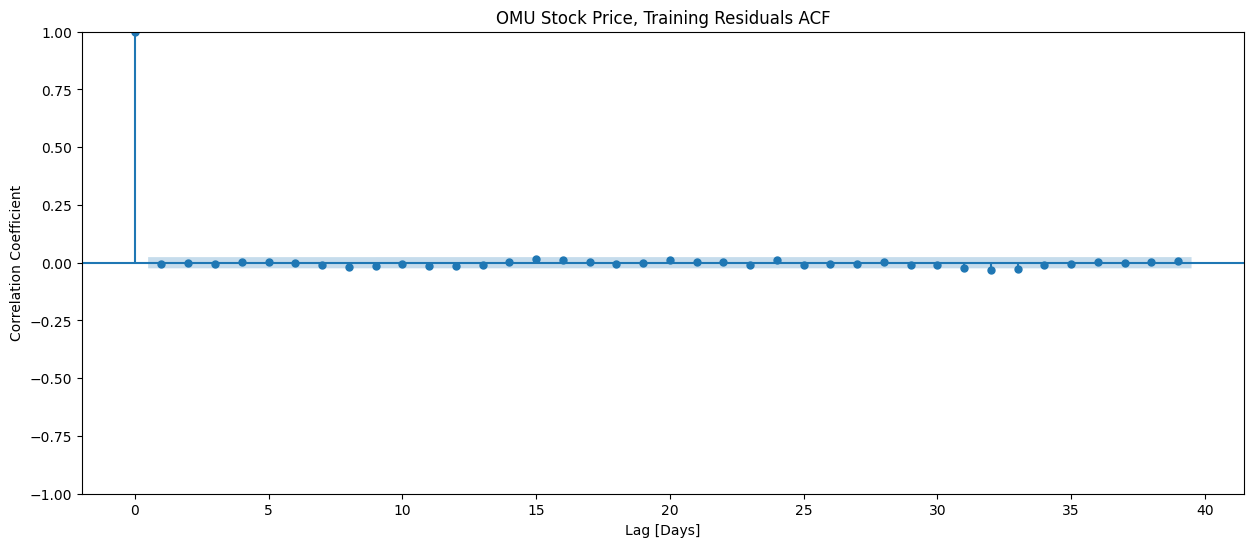

In [288]:
# ACF plot :Residuals
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(residuals,ax=ax)
plt.xlabel("Lag [Days]");
plt.ylabel("Correlation Coefficient");
plt.title("OMU Stock Price, Training Residuals ACF");

### The autocorrelation function (ACF) plot for the residuals suggests that the predictive power has been effectively removed, indicating that the ARIMA model has captured the underlying patterns in Old Mutual's stock price. The absence of significant autocorrelation implies that the residuals exhibit white noise behavior, confirming that no further structure remains in the data that could be exploited for better forecasting

# Fit and Train The Model with the best parameters

In [291]:
best_model = ARIMA(y_test, order=(1, 1, 1))  
model_fit = best_model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  654
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1745.554
Date:                Wed, 14 May 2025   AIC                           3497.108
Time:                        14:09:40   BIC                           3510.553
Sample:                             0   HQIC                          3502.322
                                - 654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0355      0.020      1.773      0.076      -0.004       0.075
ma.L1         -0.6346      0.021    -30.548      0.000      -0.675      -0.594
sigma2        12.2762      0.066    186.931      0.0

In [292]:
from statsmodels.tsa.arima.model import ARIMA

train_size = int(len(df) * 0.8)  # Use at least 80% of the data for training
train, test = df['Price'][:train_size], df['Price'][train_size:]

history = list(train)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))  # Adjust p, d, q
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])  # Append actual value to history


# Communication of Results

In [293]:

y_true = test.values  # Actual values from the test dataset
y_pred = predictions  # Model's predicted values
mae = mean_absolute_error(y_true, y_pred)

print(f"Mean Absolute Error (MAE)$: {mae:.4f}")


Mean Absolute Error (MAE)$: 1.0372


### The test Model perfomed even better on the Test Data with a Mean ABsolute Error of 1.04 which is lower than the training MAE of $1.12

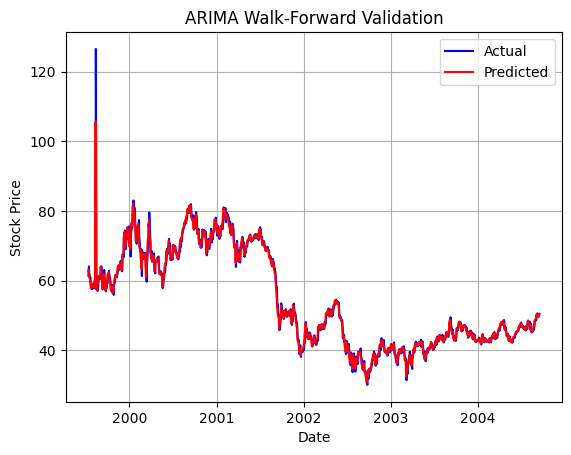

In [243]:
import matplotlib.pyplot as plt
plt.plot(test.index, test, label="Actual", color="blue")
plt.plot(test.index, predictions, label="Predicted", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("ARIMA Walk-Forward Validation")
plt.legend()
plt.grid()
plt.show()


### Looking at the plot ,it looks like the model's predictions were very close to the actual values,meaning that our model is doing great

# Concluison

### In this study, we applied ARIMA modeling to forecast Old Mutual’s stock price trends on the London Stock Exchange (LSE) using historical data sourced from Investing.com. Through data preprocessing, stationarity tests, and walk-forward validation, we assessed the model’s predictive accuracy and limitations.

### The results indicate that ARIMA models can effectively capture short-term stock price patterns, but forecasting accuracy may decline during periods of high volatility. While first-order differencing stabilized the dataset, fluctuations in market conditions still affected precision, suggesting that additional modeling techniques,such as SARIMA (Seasonal ARIMA) or hybrid approaches incorporating machine learning may improve future predictions.